In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from itertools import product
from tqdm import tqdm 

import seaborn as sns

In [2]:
#!pip install -U imbalanced-learn

In [3]:
df = pd.read_csv("../dataset/bank-preprocessed.csv")

In [4]:
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2,0,2143,1,0,5,261,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,44,1,0,29,1,0,5,151,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,33,1,0,2,1,1,5,76,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,35,2,0,231,1,0,5,139,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,28,2,0,447,1,1,5,217,1,-1,...,0,0,1,0,0,0,0,0,0,1


# Amount of data in each class

We can see the difference between the amount of registration of class '0' is much greater than that of class '1'.

In [5]:
df['y'].value_counts()

0    38257
1     5037
Name: y, dtype: int64

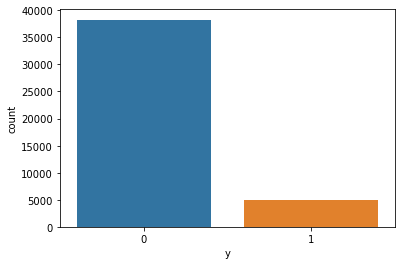

In [6]:
ax = sns.countplot(x="y", data=df)

# Splitting data

In [7]:
X = df.drop(["y"], axis = 1).to_numpy()
y = df["y"].values

## Splitting data into training and testing

In [8]:
SEED = 42

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED, stratify=y)

# Validating the model

In [10]:
n_estimators = [10, 100]
criterions = ["gini", "entropy"]
max_features = ["sqrt", "auto", "log2"]

In [11]:
search_space = tuple(product(n_estimators, criterions, max_features))

print("Amount of training sets that will be validate: ", len(search_space))

Amount of training sets that will be validate:  12


In [12]:
def search_cross_valid(search_space, X_train, y_train, SEED=42):
    scores_test, scores_valid, params = [], [], []

    for n_est, crt, max_f in tqdm(search_space, desc="Treinamento: "):
        model = RandomForestClassifier(n_estimators=n_est, criterion=crt, max_features=max_f, random_state=SEED)

        cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)

        scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
        
        model.fit(X_train, y_train)
        score_test = precision_score(y_test, model.predict(X_test), average="micro")
        
        print('Mean f1: %.3f' % np.mean(scores))
        print('Accuracy test: %.3f' % score_test)

        parm = dict(n_estimators=n_est, criterion=crt, max_features=max_f)

        print("Parameters: ", parm)
        print("Score of validation: ", np.mean(scores))

        scores_valid.append(np.mean(scores))
        scores_test.append(score_test)
        params.append(parm)

    zipped_results = zip(scores_test, scores_valid, params)
    best_result =  max(zipped_results, key = lambda res: res[1])
    best_score_test, best_score_valid, best_params = best_result

    print('------------------------------')
    print("Best parameters: ", best_params)
    print("Best validation score: ", best_score_valid)
    print("Best validation score: ", best_score_test)
    
    return scores_test, best_score_test, scores_valid, best_score_valid, params, best_params

In [13]:
scores_test, best_score_test, scores_valid, best_score_valid, params, best_params = search_cross_valid(search_space, X_train, y_train)

Treinamento:   8%|▊         | 1/12 [00:03<00:35,  3.19s/it]

Mean f1: 0.902
Accuracy test: 0.898
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.901573071380126


Treinamento:  17%|█▋        | 2/12 [00:07<00:36,  3.63s/it]

Mean f1: 0.902
Accuracy test: 0.898
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.901573071380126


Treinamento:  25%|██▌       | 3/12 [00:10<00:31,  3.50s/it]

Mean f1: 0.902
Accuracy test: 0.897
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9017176799408327


Treinamento:  33%|███▎      | 4/12 [00:13<00:27,  3.47s/it]

Mean f1: 0.899
Accuracy test: 0.900
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8991770308220388


Treinamento:  42%|████▏     | 5/12 [00:17<00:24,  3.55s/it]

Mean f1: 0.899
Accuracy test: 0.900
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8991770308220388


Treinamento:  50%|█████     | 6/12 [00:20<00:20,  3.43s/it]

Mean f1: 0.901
Accuracy test: 0.897
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9010535826110267


Treinamento:  58%|█████▊    | 7/12 [00:35<00:35,  7.14s/it]

Mean f1: 0.906
Accuracy test: 0.902
Parameters:  {'n_estimators': 100, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.9063083244246835


Treinamento:  67%|██████▋   | 8/12 [00:46<00:33,  8.47s/it]

Mean f1: 0.906
Accuracy test: 0.902
Parameters:  {'n_estimators': 100, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.9063083244246835


Treinamento:  75%|███████▌  | 9/12 [01:10<00:39, 13.15s/it]

Mean f1: 0.905
Accuracy test: 0.904
Parameters:  {'n_estimators': 100, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.9053267334854308


Treinamento:  83%|████████▎ | 10/12 [01:22<00:25, 12.93s/it]

Mean f1: 0.905
Accuracy test: 0.905
Parameters:  {'n_estimators': 100, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.9054134386010073


Treinamento:  92%|█████████▏| 11/12 [01:37<00:13, 13.44s/it]

Mean f1: 0.905
Accuracy test: 0.905
Parameters:  {'n_estimators': 100, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.9054134386010073


Treinamento: 100%|██████████| 12/12 [01:59<00:00,  9.92s/it]

Mean f1: 0.906
Accuracy test: 0.902
Parameters:  {'n_estimators': 100, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.9055865820728402
------------------------------
Best parameters:  {'n_estimators': 100, 'criterion': 'gini', 'max_features': 'sqrt'}
Best validation score:  0.9063083244246835
Best validation score:  0.9020672133040767


In [14]:
results_rf = pd.DataFrame({'model': 'Random Forest', 'parameters': params, 'mean_test_score': scores_valid})

results_rf

,model,parameters,mean_test_score
0,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.901573
1,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.901573
2,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.901718
3,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.899177
4,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.899177
5,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.901054
6,Random Forest,"{'n_estimators': 100, 'criterion': 'gini', 'ma...",0.906308
7,Random Forest,"{'n_estimators': 100, 'criterion': 'gini', 'ma...",0.906308
8,Random Forest,"{'n_estimators': 100, 'criterion': 'gini', 'ma...",0.905327
9,Random Forest,"{'n_estimators': 100, 'criterion': 'entropy', ...",0.905413


Podemos observar que os scores do train e do testes dos 10 melhores modelos estão todos acima de 90%, sendo que em alguns casos está ocorrendo overfitting. 

# Model with best results

In [15]:
model_best = RandomForestClassifier(**best_params, random_state=SEED)

In [16]:
model_best.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', random_state=42)

In [17]:
print(classification_report(y_test, model_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7652
           1       0.64      0.37      0.47      1007

    accuracy                           0.90      8659
   macro avg       0.78      0.67      0.71      8659
weighted avg       0.89      0.90      0.89      8659



Notamos que o recall (número de acertos) para a classe 0 é muito alta, por outro lado o da classe 1 é bem baixa.

Isso só reforça o que estamos investigando, nosso modelo está enviesado, ele aprendeu mais sobre a classe que tinha uma maior quantidade de exemplos. Constatamos que os nossos dados estão desbalanceados, então para resolver esse problema e melhorar nosso modelo iremos realizar um tratamento nesses dados.

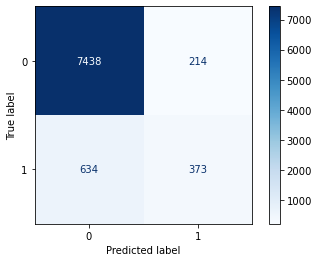

In [18]:
ConfusionMatrixDisplay.from_estimator(model_best, X_test, y_test, cmap='Blues', values_format='d')

A matriz de confusão nos mostra o número exato de registros classificados por classe.

Temos 659 registos classificados como sendo da classe 0 quando na verdade eram da classe 1.

# Aplicando NearMiss
NearMiss (https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.NearMiss.html) – É um algoritmo de undersampling que consiste em reduzir de forma aleatória os exemplos da classe majoritária, porém ele seleciona os exemplos com base na distância.

In [20]:
X = df.drop(["y"], axis = 1)
y = df["y"]
nr = NearMiss()
X, y = nr.fit_resample(X, y)


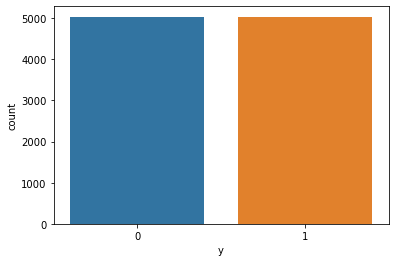

In [21]:
ax = sns.countplot(x=y)

Depois da aplicação do NearMiss podemos observar que as classes estão balanceadas.

In [22]:
X

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,32,1,0,0,1,0,19,188,2,-1,...,0,0,0,1,0,0,0,0,0,1
1,29,1,0,0,1,0,16,186,4,-1,...,0,0,0,0,0,0,0,0,0,1
2,31,2,0,0,1,0,15,185,2,-1,...,0,0,0,0,0,0,0,0,0,1
3,39,1,0,1,1,0,26,506,2,-1,...,0,0,1,0,0,0,0,0,0,1
4,33,1,0,0,0,0,20,190,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,73,1,0,2850,0,0,17,300,1,40,...,0,0,0,1,0,0,1,0,0,0
10070,25,1,0,505,0,1,17,386,2,-1,...,0,0,0,1,0,0,0,0,0,1
10071,51,2,0,825,0,0,17,977,3,-1,...,0,0,0,1,0,0,0,0,0,1
10072,71,0,0,1729,0,0,17,456,2,-1,...,0,0,0,1,0,0,0,0,0,1


In [23]:
X["y"] = y
X

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,32,1,0,0,1,0,19,188,2,-1,...,0,0,1,0,0,0,0,0,1,0
1,29,1,0,0,1,0,16,186,4,-1,...,0,0,0,0,0,0,0,0,1,0
2,31,2,0,0,1,0,15,185,2,-1,...,0,0,0,0,0,0,0,0,1,0
3,39,1,0,1,1,0,26,506,2,-1,...,0,1,0,0,0,0,0,0,1,0
4,33,1,0,0,0,0,20,190,2,-1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,73,1,0,2850,0,0,17,300,1,40,...,0,0,1,0,0,1,0,0,0,1
10070,25,1,0,505,0,1,17,386,2,-1,...,0,0,1,0,0,0,0,0,1,1
10071,51,2,0,825,0,0,17,977,3,-1,...,0,0,1,0,0,0,0,0,1,1
10072,71,0,0,1729,0,0,17,456,2,-1,...,0,0,1,0,0,0,0,0,1,1


In [24]:
X.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'y'],
      dtype='object')

In [25]:
X.to_csv("../dataset/bank-balanced.csv")